

# Begleitendes Jupyter Notebook zur Masterarbeit <br>
# Digitale Rekonstruktion der Sammlung von Danzig Baldaev: <br>
## Erfassung, Modellierung und Analyse



# Einleitung

Das vorliegende Jupyter Notebook dient nicht im Sinne eines Computational Essays, also keiner narrativen, schrittweise erklärten Analyse mit interpretativem Anspruch, sondern als begleitendes Dokument, mit dem Ziel, Transparenz über die methodische Umsetzung und technische Vorgehensweise im Rahmen meiner Arbeit zu schaffen. Es dokumentiert die zentralen Verarbeitungsschritte der Daten, insbesondere die Modellierung und strukturierte Aufbereitung der Baldaev-Sammlung in einem XML-basierten Format (LIDO).
Die folgenden Seiten wurden mit LaTeX erstellt, um den enthaltenen Code in druckfähiger Form abzubilden. Der Quellcode sowie die zugehörigen Erklärungen sind als technischer Anhang zu verstehen und dienen der Dokumentation und Nachvollziehbarkeit. Teile des verwendeten Codes wurden mithilfe von „ChatGPT (GPT-4, OpenAI)“ generiert. Der Einsatz erfolgte zur tech
nischen Unterstützung, nicht zur inhaltlichen Argumentation oder Bewertung.  Das Github Repository befindet sich auf:
 https://github.com/DaniistSahne/Masterarbeit

Im folgenden Codeblock sind zunächst die importierten Module aufgelistet. Für die Datenanalyse und tabellarische Verarbeitung wurden pandas, numpy sowie Methoden zur Datenaufteilung aus scikit-learn verwendet. Die Visualisierung von Bildern und Diagrammen erfolgte über matplotlib und IPython-Ausgabehilfen. Zur Umsetzung der Objekterkennung und automatisierten Bildanalyse wurde YOLO aus dem ultralytics-Framework in Kombination mit PyTorch eingesetzt. Für die Verarbeitung und Konvertierung von Bild- und PDF-Dateien dienten Pillow, pdf2image sowie systemnahe Module wie os, shutil und pathlib. Zur Integration externer Datenquellen und Schnittstellen wurde requests verwendet, während strukturierte XML-Dateien im LIDO-Format mit lxml verarbeitet wurden. Die Notebook-spezifische Darstellung interaktiver Inhalte wurde durch IPython.display unterstützt.

In [1]:
#import

#  Datenanalyse & Tabellenverarbeitung 
import pandas as pd
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
import numpy as np
import random
import time
import json
import yaml

#  Visualisierung 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, Image

#  Machine Learning & Deep Learning 
import torch
import ultralytics
from ultralytics import YOLO

#  Bild- und Dateiverarbeitung 
from PIL import Image
from pdf2image import convert_from_path
import os
import glob
import shutil
from shutil import copy2
from pathlib import Path

#  Webanfragen / API 
import requests

#  XML-Verarbeitung (für LIDO) 
from lxml import etree

#  Jupyter-spezifisch 
from IPython import display


## Organisation

In diesem Abschnitt erfolgte die Vorbereitung der Verzeichnisstruktur für die Bilddaten. Die ausgewählten Abbildungen sind mithilfe eines Zeutschel-Zeta-Aufsichtsscanners digitalisiert worden. Für jede Publikation liegt dabei ein eigener Unterordner vor.

In [2]:
#Anlegen der Bildordner

# Basispfad Bilder
img_base_path = "C:/Users/daniil/Desktop/Masterarbeit/data/images"

# Namen der Ordner 
folder_names = [
    "rcte_1",  # Russian Criminal Tattoo Encyclopedia Volume 1
    "rcte_2",  # Russian Criminal Tattoo Encyclopedia Volume 2
    "rcte_3",  # Russian Criminal Tattoo Encyclopedia Volume 3
    "TZ",      # Taturovki Zakluchennyh. Albom
    "rcta"     # Russian Criminal Tattoo Archive
]

# Erstellung Ordner
for folder in folder_names:
    folder_path = os.path.join(img_base_path, folder)
    os.makedirs(folder_path, exist_ok=True)
    print(f"Erstellt: {folder_path}")

Erstellt: C:/Users/daniil/Desktop/Masterarbeit/data/images\rcte_1
Erstellt: C:/Users/daniil/Desktop/Masterarbeit/data/images\rcte_2
Erstellt: C:/Users/daniil/Desktop/Masterarbeit/data/images\rcte_3
Erstellt: C:/Users/daniil/Desktop/Masterarbeit/data/images\TZ
Erstellt: C:/Users/daniil/Desktop/Masterarbeit/data/images\rcta


Die Bilder können dabei automatisch mit Hilfe eines Codes oder manuell in die jeweiligen Ordner eingefügt werden. Für diese Arbeit geschah dies manuell. 

### Erstellung lokaler JSON Datei

Anschließend erfolgte für jede Bilddatei die Erstellung eines strukturierten Metadateneintrags, der in einer JSON-Datei gespeichert wurde. Zunächst kam ein
sogenanntes „Mapping“ zum Einsatz, das die technischen Ordnernamen wie „rcte_1“
zu den vollständigen Titeln der jeweiligen Publikationen zuordnete (z.B. „Russian
Criminal Tattoo Encyclopaedia Volume 1“). Diese Zuordnung erleichterte die Lesbarkeit und stellte eine eindeutige Herkunftskennzeichnung jeder Zeichnung sicher.
Daraufhin wurde eine leere Liste mit dem Namen „drawings_metadata“ angelegt,
in der alle Einträge gesammelt wurden. Zur eindeutigen Identifizierung diente eine Zählvariable („current_id“). Im Anschluss durchlief das Skript sämtliche zuvor
definierte Ordner. Für jede gefundene Bilddatei wurde ein Dictionary mit den entsprechenden eigens erstellten Metadatenfeldern generiert. Dabei verdeutlicht dieser
Schritt die Entwicklung von eigens entworfenen Metadatenfeldern hin zu einer späteren Standardisierung im Sinne des „Minimaldatensatzes“ und des internationalen
XML-Schemas nach LIDO. Die initiale Struktur diente somit nicht nur der Erfassung relevanter Informationen, sondern ermöglichte zugleich eine nachvollziehbare
Überleitung zu den normierten Kategorien der Kulturerbe-Dokumentation

Metadatenfelder:

 • ID–fortlaufende Nummer jeder Zeichnung <br>
 • Filename– Dateiname des Bildes <br>
 • publishedin– zugeordneter Publikationstitel <br>
 • page– Seitenzahl der Quelle <br>
 • timedocumented, timemade– Zeit der Dokumentation bzw. Herstellung <br>
 • geografische Felder– Ort, Adresse, Stadt, Region, Land (Dokumentierung und 
 Herstellung) <br>
 • sex, group– geschlechtliche/soziale Einordnung <br>
 • bodypart– Körperstelle des Tattoos<br>
 • summary\_description– Beschreibung auf ikonographischer Ebene<br>
 • iconclass_codes– kodierte Einordnung nach dem Iconclass-System<br>
 • tags– eigene Verschlagwortung<br>
 • text_xx– enthaltene Texte in verschiedenen Sprachen<br>
 • text_trans– Übersetzung falls englischer Text<br>
 • themes– thematische Einordnung<br>
 • criminalcode– zugeordnete Paragraphen der Strafverfolgung<br>

In [4]:
#Erstellen der Metadatenstruktur und Export als JSON

# Mapping von Ordnernamen auf vollständige Titel
publishedin_mapping = {
    "rcte_1": "Russian Criminal Tattoo Encyclopaedia Volume 1",
    "rcte_2": "Russian Criminal Tattoo Encyclopaedia Volume 2",
    "rcte_3": "Russian Criminal Tattoo Encyclopaedia Volume 3",
    "TZ": "Taturovki Zaklyuchennykh. Albom",
    "rcta": "Russian Criminal Tattoo Archive"
}

# Pfad zur Ziel-JSON-Datei
output_json = "C:/Users/daniil/Desktop/Masterarbeit/data/metadata/baldaev_metadata.json"

# Liste zur Speicherung der Metadaten
drawings_metadata = []
current_id = 1

# Durchlaufe alle Ordner im img_base_path
for folder in folder_names:
    folder_path = os.path.join(img_base_path, folder)
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            drawing_data = {
                "ID": current_id,
                "Filename": filename,
                "publishedin": publishedin_mapping.get(folder, folder),
                "page": None,
                "timedocumented": [],
                "timemade": [],
                "place_documented": None,
                "address_documented": None,
                "city_documented": None,
                "region_documented": [],
                "country_documented": [],
                "placemade": [],
                "address_made": None,
                "city_made": None,
                "region_made": [],
                "country_made": [],
                "sex": [],
                "group": [],
                "bodypart": [],
                "summary_description": None,
                "iconclass_codes": {},
                "tags": [],
                "text_ru": [],
                "text_eng": [],
                "text_gr": [],
                "text_ger": [],
                "text_ita": [],
                "text_fr": [],
                "text_lat": [],
                "text_geo": [],
                "text_gre": [],
                "text_arab": [],
                "text_tat": [],
                "text_trans": [],
                "themes": [],
                "criminalcode": []
            }
            drawings_metadata.append(drawing_data)
            current_id += 1

# Ordner erstellen, falls nicht vorhanden
os.makedirs(os.path.dirname(output_json), exist_ok=True)

# Metadaten als JSON speichern
with open(output_json, 'w', encoding='utf-8') as f:
    json.dump({"drawings": drawings_metadata}, f, ensure_ascii=False, indent=4)

print("Metadaten wurden gespeichert in:", output_json)

Metadaten wurden gespeichert in: C:/Users/daniil/Desktop/Masterarbeit/data/metadata/baldaev_metadata.json


# Stichprobengenerierung

Um eine exemplarische Analyse einzelner Motive durchzuführen, wurde aus jeder Publikation der Sammlung per Zufallsverfahren jeweils ein Datensatz ausgewählt. Ziel war es, durch gezielte Stichproben einen Einblick in die Bandbreite der Inhalte zu gewinnen, ohne die gesamte Datenmenge manuell durchsehen zu müssen. Das Skript gruppierte die vorhandenen Einträge zunächst anhand des Feldes "publishedin" und wählte anschließend pro Gruppe (Publikation) eine zufällige Zeichnung aus.

In [ ]:
#Zufallsauswahl eines Eintrags pro Publikation

# Pfad zur JSON-Datei
json_path = r"C:\Users\daniil\Desktop\Masterarbeit\data\metadata\baldaev_metadata.json"

# JSON-Datei laden
with open(json_path, "r", encoding="utf-8") as file:
    metadata = json.load(file)

# Gruppierung der Tattoos nach 'publishedin'
grouped_by_publication = {}
for entry in metadata:
    pub = entry.get("publishedin", "Unknown")
    grouped_by_publication.setdefault(pub, []).append(entry)

# Zufällige Auswahl pro Publikation
selected_tattoos = {pub: random.choice(entries) for pub, entries in grouped_by_publication.items() if entries}

# Ergebnisse ausgeben
for pub, tattoo in selected_tattoos.items():
    print(f"Publikation: {pub}\n  ID: {tattoo['ID']}\n" + "-" * 40)

Publikation: Russian_Criminal_Tattoo_Encyclopaedia_vol_1
  ID: 84
----------------------------------------
Publikation: Taturovki_Zakluchennyh_Album
  ID: 1403
----------------------------------------
Publikation: Russian_Criminal_Tattoo_Encyclopaedia_vol_2
  ID: 593
----------------------------------------
Publikation: Russian_Criminal_Tattoo_Encyclopaedia_vol_3
  ID: 940
----------------------------------------
Publikation: Russian_Criminal_Tattoo_Archive
  ID: 1580
----------------------------------------


# Automatisierter Zuschnitt der Bildmotive mittels Machine Learning

Ein Teil des technischen Workflows bestand in der Entwicklung eines automatisierten Zuschnittverfahrens für die gescannten Buchseiten, mit dem Ziel den Arbeitsprozess zu erleichtern, etwa durch das gezielte Abrufen einzelner Bildmotive oder der ständigen Verfügbarkeit der Bilder. Da die Seiten häufig neben Bildern auch Text, Seitenzahlen oder mehrere Motive enthielten, war eine vorherige Trennung dieser Elemente erforderlich.
Als Grundlage diente das Annotationstool "Label Studio", in dem relevante Bildinhalte manuell markiert wurden. Annotiert wurden dabei konkret:

• die eigentlichen Tattoo-Motive, <br>
• enthaltene Texte, <br>
• sichtbare Seitennummern, <br>
• sowie Finger. <br>



Folgendes Labeling-Interface wurde dabei verwendet:

In [ ]:
<View>
  <Image name="image" value="$image" zoomControl="true" zoom="true" rotateControl="true"/>
  <RectangleLabels name="label" toName="image">
    
    
  <Label value="Text" background="#FFA39E"/><Label value="Motiv" background="#1137d0"/><Label value="Finger" background="#FFC069"/><Label value="Seite" background="#9dffb6"/></RectangleLabels>
</View>

Die annotierten Bilder wurden mit den labels in den manuell erstellten Ordner "train_data" gespeichert.

Für das Training wurde ein neuronales Netz auf Basis von „YOLO“ (You Only
Look Once) verwendet, das auf „PyTorch“ basiert. Das Ziel war es, dem Modell
beizubringen, visuelle Merkmale der Motive so zu erkennen, dass eine automatisierte
Zuschneidung der digitalisierten Seiten möglich ist. Dadurch konnte der zuvor
manuell durchgeführte und sehr zeitaufwändige Arbeitsschritt der Motiverkennung
effizient automatisiert werden. Bevor das Training beginnen konnte, wurde zunächst
überprüft, ob eine geeignete GPU zur Verfügung stand und ob alle notwendigen
Bibliotheken korrekt installiert waren:

In [8]:
# GPU-Verfügbarkeit prüfen

!nvidia-smi


Sun May  4 16:53:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P0             15W /   60W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Vorbereitung des Trainings

Zur Vorbereitung des Modelltrainings wurde der ursprüngliche Datensatz, bestehend aus annotierten Bilddateien und zugehörigen Label-Dateien, in Trainings- und Validierungsdaten aufgeteilt. Die Quelldaten befanden sich in einem separaten Verzeichnis und wurden für die Weiterverarbeitung in eine neue Ordnerstruktur überführt. Diese umfasste jeweils separate Unterordner für Bilder und Labels, getrennt nach "train" und "valid".

In [71]:
folder = 'C:/Users/daniil/Desktop/Masterarbeit/data/train_data/images'

for filename in os.listdir(folder):
    name, ext = os.path.splitext(filename)
    if ext.lower() == '.jpg':
        old_path = os.path.join(folder, filename)
        new_path = os.path.join(folder, name + '.png')
        os.rename(old_path, new_path)


In [72]:
# Aufteiling in Trainings- und Validierungsdaten

original_dir = 'C:/Users/daniil/Desktop/Masterarbeit/data/train_data'
new_dir = 'C:/Users/daniil/Desktop/Masterarbeit/data/prep_train_data'

original_images = os.path.join(original_dir, 'images')
original_labels = os.path.join(original_dir, 'labels')

#Neues Verzeichnis anlegen

if not os.path.exists(new_dir):
    os.makedirs(new_dir)

#Zielverzeichnisse für Training und Validierung

train_dir = os.path.join(new_dir, 'train')
val_dir = os.path.join(new_dir, 'valid')
os.makedirs(os.path.join(train_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'labels'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'labels'), exist_ok=True)

In [73]:
# Dateinamen ohne Erweiterung, um für die Datei-Endungen in image und labels nutzen zu können

basenames = [os.path.splitext(file)[0] for file in os.listdir(original_images)
             if file.lower().endswith(('.png', '.jpg', '.jpeg'))]



In [74]:
# Daten in Training und Validierung aufteilen

train_files, val_files = train_test_split(basenames, test_size=1/3, random_state=42)

In [75]:
for basename in train_files:
    shutil.copy(os.path.join(original_images, basename + '.png'), os.path.join(train_dir, 'images', basename + '.png'))
    shutil.copy(os.path.join(original_labels, basename + '.txt'), os.path.join(train_dir, 'labels', basename + '.txt'))

for basename in val_files:
    shutil.copy(os.path.join(original_images, basename + '.png'), os.path.join(val_dir, 'images', basename + '.png'))
    shutil.copy(os.path.join(original_labels, basename + '.txt'), os.path.join(val_dir, 'labels', basename + '.txt'))

## Modeltraining und Anwendung

Für das Training kam ein vortrainiertes „YOLOv8“-Modell zum Einsatz, das über
200 Epochen hinweg auf die annotierten Trainingsdaten weitertrainiert wurde. Die
Klassenstruktur wurde in einer separaten „YAML“-Datei definiert. Nach Abschluss
des Trainings wurde das beste Modell gespeichert und für die Vorhersage auf neuen
Bilddaten verwendet. <br>

In [ ]:
#Modell laden und trainieren
model = YOLO("yolov8l.pt")  # vortrainiertes Yolo Model laden. Standardspeicherort =  Jup-Notebook Speicherort
model.train(data='C:/Users/daniil/Desktop/Masterarbeit/src/tattoos.yaml', # YAML Standardspeichertort = Jup-Notebook
            epochs=200,
            patience=100,
            batch=8,
            pretrained=True,
            project="C:/Users/daniil/Desktop/Masterarbeit/data/train_ergebnisse",
            optimizer="Adam")

Nach dem Training wurde das beste Modell geladen und auf den Validierungsdatensatz angewendet.

In [ ]:
#  Bestes Modell laden und Vorhersagen machen
model_best = YOLO('C:/Users/daniil/Desktop/Masterarbeit/data/train_ergebnisse/train/weights/best.pt')

model_best.predict("C:/Users/daniil/Desktop/Masterarbeit/data/prep_train_data/valid/images",
                   save=True,
                   imgsz=640,
                   conf=0.3,
                   iou=0.5,
                   classes=1,
                   save_txt=True,
                   save_conf=True,
                   line_width=1)

## Automatisierte Vorhersage auf mehreren Bildordnern

Schließlich wurde das trainierte YOLO-Modell auf alle sechs Unterordner angewendet.

In [ ]:
#  Modell laden und auf jeden neuen Ordner Vorhersagen laufen lassen

model = YOLO('C:/Users/daniil/Desktop/Masterarbeit/data/train_ergebnisse/train/weights/best.pt')

# Loop über die Ordner
for i in range(1, num_folders + 1):
    predict_folder = base_dir / f'Zeichnungen_einzeln_{i}'
    print(f' Starte Prediction für Ordner: {predict_folder}')
    model.predict(
        source=str(predict_folder),
        save=True,
        save_txt=True,
        conf=0.5,
        visualize=True,
        save_conf=True,
        save_crop=True,
        show_labels=True
    )

## Zusammenführung der zugeschnittenen Motive

Abschließend wurden die zuvor erzeugten Bildausschnitte aus den verschiedenen Vorhersageordnern "predict5" bis "predict10" in einem zentralen Verzeichnis zusammengeführt. Jeder dieser Ordner enthielt die mittels YOLO erkannten und ausgeschnittenen Bildmotive. Das Ziel bestand darin, alle relevanten Einzelelemente aus der Gesamtmenge der gescannten Seiten systematisch in ein einheitliches Verzeichnis zu übertragen. Dabei wurde automatisiert überprüft, ob die entsprechenden Quellordner existierten, um unnötige Fehler bei fehlgeschlagenen Vorhersagen zu vermeiden. Zudem wurde sichergestellt, dass bereits vorhandene Dateien im Zielordner nicht erneut kopiert wurden. So konnte ein konsistenter und duplikatfreier Datensatz erstellt werden. 

In [ ]:
# Zusammenführen der zugeschnittenen Motive

# Zielverzeichnis (jetzt angepasst!)
zielverzeichnis = Path('C:/Users/daniil/Desktop/Masterarbeit/data/images/images_cut')
zielverzeichnis.mkdir(parents=True, exist_ok=True)

# Quellverzeichnisse automatisch aufbauen (von predict5 bis predict10)
quellverzeichnisse = []
for i in range(5, 11):  # predict5 bis predict10
    quellverzeichnisse.append(Path(f'C:/Users/daniil/Desktop/Masterarbeit/src/runs/detect/predict{i}/crops/Motiv'))

# Dateien kopieren
for quellverzeichnis in quellverzeichnisse:
    if quellverzeichnis.exists():
        for datei in quellverzeichnis.iterdir():
            if datei.is_file():
                zieldateipfad = zielverzeichnis / datei.name
                if not zieldateipfad.exists():
                    copy2(datei, zieldateipfad)
                else:
                    print(f"Datei {zieldateipfad} existiert bereits. Überspringe.")
    else:
        print(f" Quellverzeichnis {quellverzeichnis} existiert nicht. Überspringe.")

print(" Alle zugeschnittenen Bilder wurden erfolgreich in 'images_cut' gespeichert.")


# Semantische Anreicherung mit Iconclass

Im folgenden  Abschnitt wurde ein automatisierter Prozess zur semantischen Anreicherung der eigen erstellten Schlagwörter, den "Tags", aus den Bildmetadaten mittels des Iconclass-Systems umgesetzt. Ziel war es, die ursprünglich manuell vergebenen Begriffe mit etablierten ikonographischen Notationen zu verknüpfen, um eine inhaltliche Strukturierung der Bildmotive auf normierter Basis zu ermöglichen. <br>

Zunächst wurden sämtliche "Tags" aus der bestehenden Metadaten-Datei extrahiert. Durch die Verwendung eines "set-Objekts" konnten dabei doppelte Einträge automatisch entfernt werden. Die resultierende Liste wurde alphabetisch sortiert und als Textdatei gespeichert, die als Ausgangspunkt für die Iconclass-Anfragen diente.

In [ ]:
# Extraktion und Speicherung der Tags aus JSON-Metadaten

# Pfad zur Metadaten-JSON
json_path = r"C:/Users/daniil/Desktop/Masterarbeit/data/Metadaten/baldaev_metadata.json"

# Pfad zur neuen Tags-Textdatei
output_tags_txt = r"C:/Users/daniil/Desktop/Masterarbeit/data/metadata/output_tags.txt"

# Lade die Zeichnungen-Metadaten
with open(json_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# Alle Tags sammeln
all_tags = set()  # Set, damit keine doppelten Tags gespeichert werden

for drawing in data.get("drawings", []):
    tags = drawing.get("tags", [])
    for tag in tags:
        clean_tag = tag.strip()
        if clean_tag:
            all_tags.add(clean_tag)

# Sortieren für bessere Übersicht
all_tags = sorted(all_tags)

# Speichere die Tags in die Textdatei
with open(output_tags_txt, 'w', encoding='utf-8') as file:
    for tag in all_tags:
        file.write(tag + "\n")


Anschließend wurde für jeden "Tag" eine Abfrage an die öffentliche API des Iconclass-Systems durchgeführt. Pro Begriff wurden dabei bis zu zehn passende Notationen mit Kurzbeschreibungen ermittelt. Zur Reduktion der Serverlast wurden automatische Pausen zwischen den Anfragen eingebaut. Zudem wurde der Fortschritt regelmäßig in einer temporären Datei gesichert, um eine Wiederaufnahme bei Abbruch zu ermöglichen. Die Ergebnisse bildeten die Grundlage für die spätere iconclass-basierte Verschlagwortung im XML-Datenmodell.

In [ ]:
# Abfrage von ICONCLASS-Notationen und Beschreibung zu den Tags

def search_iconclass(term, retries=3):
    """Durchsucht die Iconclass-API nach einem Begriff und gibt die Ergebnisse zurück."""
    url = "https://iconclass.org/api/search"
    params = {'q': term, 'size': 10}  # Begrenze die Anzahl der Ergebnisse
    for attempt in range(retries):
        try:
            response = requests.get(url, params=params, timeout=10)
            if response.status_code == 200:
                results = response.json().get("result", [])
                
                # Überprüfen, ob die Ergebnisse Zeichenketten oder Dictionaries sind
                if isinstance(results, list) and all(isinstance(item, str) for item in results):
                    return [{"notation": item, "description": get_description_from_iconclass(item)} for item in results]
                
                return [
                    {
                        "notation": item.get("notation", ""),
                        "description": item.get("txt", {}).get("en", "No description")
                    }
                    for item in results
                ]
            else:
                print(f"Fehler bei der Suche nach '{term}': Status-Code {response.status_code}")
        except requests.RequestException as e:
            print(f"Anfrage für '{term}' fehlgeschlagen: {e}")
        time.sleep(2)  # Backoff bei Fehlern
    print(f"Kein Ergebnis für '{term}' nach {retries} Versuchen.")
    return []

# Funktion um Beschreibung eines Iconclass Codes abzurufen
def get_description_from_iconclass(notation, retries=3):
    """Holt die Beschreibung eines Iconclass-Notationscodes."""
    url = f"https://iconclass.org/{notation}.json"
    for attempt in range(retries):
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                data = response.json()
                return data.get("txt", {}).get("en", "No description")
            else:
                print(f"Fehler beim Abrufen der Beschreibung für '{notation}': Status-Code {response.status_code}")
        except requests.RequestException as e:
            print(f"Anfrage für '{notation}' fehlgeschlagen: {e}")
        time.sleep(2)
    return "No description available"

# Funktion für Pause zwischen API-Anfragen
def pause_request(interval=2.5):
    time.sleep(interval)


# Eingabe- und Ausgabepfade
input_file = r'C:\Users\daniil\Desktop\Masterarbeit\data\metadata\output_tags.txt'
output_file = r'C:\Users\daniil\Desktop\Masterarbeit\data\metadata\baldaev_metadata_iconclass.json'
temp_file = r'C:\Users\daniil\Desktop\Masterarbeit\data\metadata\tags_with_iconclass_temp.json'

# Tags laden
with open(input_file, 'r', encoding='utf-8') as file:
    tags = [line.strip() for line in file.readlines() if line.strip()]

# Zwischenspeicher für Ergebnisse
output_data = []

# Verarbeitung der Tags
for index, tag in enumerate(tags, start=1):
    print(f"Verarbeite Tag {index}/{len(tags)}: {tag}")
    notations = search_iconclass(tag)
    
    # Ergebnisse speichern
    output_data.append({
        "tag": tag,
        "iconclass_results": [
            {
                "notation": notation["notation"],
                "description": notation["description"]
            }
            for notation in notations
        ]
    })

    # Zwischenspeicherung alle 10 Tags
    if index % 10 == 0:
        with open(temp_file, 'w', encoding='utf-8') as temp_file_handle:
            json.dump(output_data, temp_file_handle, ensure_ascii=False, indent=4)
            print(f"Zwischenergebnisse nach {index} Tags gespeichert.")
        print("Längere Pause nach 10 Tags...")
        time.sleep(30)
    else:
        pause_request()

# Endergebnisse speichern
with open(output_file, 'w', encoding='utf-8') as file:
    json.dump(output_data, file, ensure_ascii=False, indent=4)

print("Verarbeitung abgeschlossen und in der Ausgabedatei gespeichert.")



# Geografische Datenextraktion und Vereinheitlichung

Der folgende Abschnitt diente der systematischen Aufbereitung, Ergänzung und
Standardisierung geografischer Informationen innerhalb der Metadaten. Ziel war
es, die Felder „place_documented“, „city_documented“, „region_documented“ und
„country_documented“ inhaltlich zu strukturieren, zu vereinheitlichen und falls
möglich, automatisch mit weiteren Kontextdaten zu ergänzen.

Zunächst wurden alle geografisch relevanten Felder aus der vorhandenen JSON-Datei extrahiert. In einem ersten Schritt erfolgte die Ausgabe aller einzigartigen Ortsangaben in eine Textdatei zur manuellen Sichtung. Zusätzlich wurde eine tabellarische Übersicht als Excel-Datei erzeugt, um die Bearbeitung und Ergänzung dieser Felder in einem für Menschen besser lesbaren Format zu ermöglichen.

In [ ]:
# Export geografischer Felder zur manuellen Bereinigung in Exce

#  Pfade definieren 
json_path = r"C:\Users\daniil\Desktop\Masterarbeit\data\metadata\baldaev_metadata_iconclass.json"
output_path = r"C:\Users\daniil\Desktop\Masterarbeit\data\locations\locations.xlsx"

#  Relevante Felder für die Geografie-Standardisierung 
fields = [
    "place_documented",
    "address_documented",
    "city_documented",
    "region_documented",
    "country_documented"
]

#  JSON laden 
with open(json_path, "r", encoding="utf-8") as file:
    data = json.load(file)

#  Helferfunktion: Listen in Strings umwandeln 
def flatten_value(value):
    if isinstance(value, list):
        return ", ".join([str(v).strip() for v in value if v])
    return str(value).strip() if value else ""

#  Alle eindeutigen Kombinationen extrahieren 
unique_entries = set()
for entry in data.get("drawings", []):
    row = tuple(flatten_value(entry.get(field)) for field in fields)
    unique_entries.add(row)

#  In DataFrame umwandeln 
df = pd.DataFrame(list(unique_entries), columns=fields)

# Zielordner anlegen, falls nicht vorhanden
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Excel-Datei schreiben =
df.to_excel(output_path, index=False)

print(f"✅ Geografische Felder wurden extrahiert und gespeichert unter:\n{output_path}")


Im Anschluss an die manuelle Standardisierung der geografischen Felder wurden
die Metadaten automatisiert um regionale und nationale Angaben ergänzt. Dazu
wurden mehrere Schritte durchgeführt:
Zunächst wurde ein manuell erstelltes Mapping verwendet, das Städtenamen
ihren jeweiligen Regionen zuordnete. Dieses „region_mapping“-Dictionary enthielt
zahlreiche Zuordnungen (z. B. „Irkutsk“ → „Irkutsk Region“) und wurde dazu
genutzt, aus dem Feld „city_documented“ die korrespondierende Region zu ermitteln.
Das Ergebnis dieser Zuordnung wurde direkt in das Feld „region_documented“
übernommen.
Im darauffolgenden Schritt wurde ein weiteres Mapping verwendet, um aus den
Regionen die entsprechenden Staaten zur Zeit der Sowjetunion abzuleiten. So konnte
z. B. „Irkutsk Region“ dem Land „Russian SFSR“ zugeordnet werden. Diese Werte
wurden automatisiert in die Felder „country_documented“ und „country_made“
eingefügt

In [ ]:
# Zuweisung von Regionen zu Städten

# Pfad zur JSON-Datei
json_path = r"C:\Users\daniil\Desktop\Masterarbeit\data\metadata\baldaev_metadata_iconclass.json"
output_json_path = r"C:\Users\daniil\Desktop\Masterarbeit\data\metadata\baldaev_metadata_regionen.json"

# Datei lesen
with open(json_path, "r", encoding="utf-8") as file:
    data = json.load(file)

# Mapping von Städten zu Regionen
region_mapping = {
    "Alma-Ata": "Almaty Region",
    "Angarsk": "Irkutsk Region",
    "Bayantümen": "Dornod Province (Mongolia)",
    "Bratsk": "Irkutsk Region",
    "Bukachacha": "Zabaykalsky Krai",
    "Chabarovsk": "Khabarovsk Krai",
    "Chelyabinsk": "Chelyabinsk Region",
    "Cheremkhovo": "Irkutsk Region",
    "Cherepovets": "Vologda Region",
    "Chita": "Zabaykalsky Krai",
    "Eastern Siberia": "Siberia",
    "Enisei Settlement": "Krasnoyarsk Region",
    "Enkhaluk": "Buryatia",
    "Fornosovo": "Leningrad Region",
    "Gorelovo": "Leningrad Region",
    "Ikey": "Irkutsk Region",
    "Irkutsk": "Irkutsk Region",
    "Kaliningrad": "Kaliningrad Region",
    "Kansk": "Krasnoyarsk Region",
    "Karaganda": "Karaganda Region",
    "Kemerovo": "Kemerovo Region",
    "Khabarovsk": "Khabarovsk Krai",
    "Kirov": "Kirov Region",
    "Kitoy": "Irkutsk Region",
    "Kolpino": "St. Petersburg Region",
    "Kolyma": "Magadan Region",
    "Kostroma": "Kostroma Region",
    "Kungur": "Perm Region",
    "Leningrad": "Leningrad Region",
    "Lesosibirsk": "Krasnoyarsk Region",
    "Luga": "Leningrad Region",
    "Metallostroy": "Leningrad Region",
    "Nadvirna": "Ivano-Frankivsk Region",
    "Nalchik": "Kabardino-Balkaria",
    "Nikolskoe": "Leningrad Region",
    "Nizhny Tagil": "Sverdlovsk Region",
    "Odessa": "Odessa Region",
    "Omsk": "Omsk Region",
    "Perm": "Perm Region",
    "Pskov": "Pskov Region",
    "Ryazan": "Ryazan Region",
    "Sablino": "Leningrad Region",
    "Sablino Settlement": "Leningrad Region",
    "Sestroretsk": "St. Petersburg Region",
    "St. Petersburg": "St. Petersburg Region",
    "Suchan": "Primorsky Krai",
    "Sverdlovsk": "Sverdlovsk Region",
    "Syktyvkar": "Komi Republic",
    "Tayshet": "Irkutsk Region",
    "Tulun": "Irkutsk Region",
    "Ukhta": "Komi Republic",
    "Ulan-Ude": "Buryatia",
    "Usolye-Sibirskoye": "Irkutsk Region",
    "Ussuriysk": "Primorsky Krai",
    "Ust-Kut": "Irkutsk Region",
    "Vladivostok": "Primorsky Krai",
    "Vologda": "Vologda Region",
    "Vyborg": "Leningrad Region",
    "Yablonovka Settlement": "Zabaykalsky Krai",
    "Zelenogorsk": "Krasnoyarsk Region",
    "Zlobino": "Krasnoyarsk Region"
}

# Helferfunktion
def flatten_value(value):
    if isinstance(value, list):
        return [str(v) for v in value if v]
    return [str(value)] if value else []

# Region aus City ableiten
for entry in data:
    cities = flatten_value(entry.get("city_documented"))
    if cities:
        assigned_regions = list({region_mapping.get(city, "Unknown Region") for city in cities})
        # Wenn nur eine Region, direkt als String speichern, sonst Liste
        entry["region_documented"] = assigned_regions if len(assigned_regions) > 1 else assigned_regions[0]

# Verzeichnis erstellen, falls nötig
os.makedirs(os.path.dirname(output_json_path), exist_ok=True)

# Datei speichern
with open(output_json_path, "w", encoding="utf-8") as output_file:
    json.dump(data, output_file, indent=4, ensure_ascii=False)

print(f"Die Datei mit den aktualisierten Regionen wurde gespeichert unter: {output_json_path}")


In [ ]:
# Zuweisung von Republiken zu Regionen

# Eingabe- und Ausgabe-Pfade
json_path = r"C:\Users\daniil\Desktop\Masterarbeit\data\metadata\baldaev_metadata_regionen.json"
output_json_path = r"C:\Users\daniil\Desktop\Masterarbeit\data\metadata\baldaev_metadata_country.json"

# Mapping Regionen → Länder (Sowjetzeit)
region_to_country_mapping = {
    "Almaty Region": "Kazakh SSR",
    "Baltic SSRs": "Soviet Union",
    "Buryat ASSR": "Russian SFSR",
    "Chelyabinsk Region": "Russian SFSR",
    "Chita Region": "Russian SFSR",
    "Dornod Province": "Mongolia",
    "Irkutsk Region": "Russian SFSR",
    "Ivano-Frankivsk Region": "Ukrainian SSR",
    "Kabardino-Balkarian ASSR": "Russian SFSR",
    "Kaliningrad Region": "Russian SFSR",
    "Karaganda Region": "Kazakh SSR",
    "Kemerovo Region": "Russian SFSR",
    "Khabarovsk Krai": "Russian SFSR",
    "Kirov Region": "Russian SFSR",
    "Komi ASSR": "Russian SFSR",
    "Kostroma Region": "Russian SFSR",
    "Krasnoyarsk Krai": "Russian SFSR",
    "Leningrad Region": "Russian SFSR",
    "Magadan Region": "Russian SFSR",
    "Odessa Region": "Ukrainian SSR",
    "Omsk Region": "Russian SFSR",
    "Perm Region": "Russian SFSR",
    "Primorsky Krai": "Russian SFSR",
    "Pskov Region": "Russian SFSR",
    "Karelian ASSR": "Russian SFSR",
    "Ryazan Region": "Russian SFSR",
    "Siberia": "Russian SFSR",
    "Sverdlovsk Region": "Russian SFSR",
    "Ural Region": "Russian SFSR",
    "Vologda Region": "Russian SFSR",
    "Zaporozhye Region": "Ukrainian SSR",
    "Arkhangelsk Region": "Russian SFSR",
    "Bryansk Region": "Russian SFSR",
    "Dagestan ASSR": "Russian SFSR",
    "Mogilev Region": "Byelorussian SSR",
    "Moscow Region": "Russian SFSR",
    "North Ossetian ASSR": "Russian SFSR",
    "Orenburg Region": "Russian SFSR",
    "Riga": "Latvian SSR",
    "Surxondaryo Region": "Uzbek SSR",
    "Tatar ASSR": "Russian SFSR",
    "Tula Region": "Russian SFSR",
    "Ural": "Russian SFSR"
}

# JSON laden
with open(json_path, "r", encoding="utf-8") as file:
    data = json.load(file)

# Helper Funktion
def get_country(region):
    if isinstance(region, list):
        return [region_to_country_mapping.get(r, "Unknown") for r in region]
    return region_to_country_mapping.get(region, "Unknown")

# Länder hinzufügen
for entry in data:
    if "region_documented" in entry and entry["region_documented"]:
        entry["country_documented"] = get_country(entry["region_documented"])
    
    if "region_made" in entry and entry["region_made"]:
        entry["country_made"] = get_country(entry["region_made"])

# Verzeichnisse erstellen falls nötig
os.makedirs(os.path.dirname(output_json_path), exist_ok=True)

# Ergebnisse speichern
with open(output_json_path, "w", encoding="utf-8") as output_file:
    json.dump(data, output_file, indent=4, ensure_ascii=False)

print(f"Länder wurden gespeichert unter: {output_json_path}")


## Automatisierte Geoverortung mit GeoNames

Um auch unbekannte oder bisher nicht zugeordnete Städte automatisiert verorten zu können, wurde zusätzlich die GeoNames-API eingesetzt. Die abgefragten Ergebnisse wurden in einer separaten JSON-Datei gespeichert. Dank eines eingebauten Fortschrittsmonitors mit Zeitschätzung sowie definierter Pausen zwischen den API-Anfragen konnte sowohl eine stabile Performance bei größeren Datenmengen gewährleistet als auch eine Überschreitung der API-Limits vermieden werden.

In [ ]:
# Eingabe- und Ausgabe-Pfade
input_file = r"C:\Users\daniil\Desktop\Masterarbeit\data\locations\city_documented_unique.txt"
json_output_file = r"C:\Users\daniil\Desktop\Masterarbeit\data\locations\city_region_mapping.json"
txt_output_file = r"C:\Users\daniil\Desktop\Masterarbeit\data\locations\city_region_mapping.txt"

# Dein GeoNames Benutzername
GEONAMES_USERNAME = "daniistsahne"  # Dein GeoNames-Accountname

def get_region_from_geonames(city_name):
    """Holt die Region einer Stadt über die GeoNames API."""
    url = "http://api.geonames.org/searchJSON"
    params = {
        "q": city_name,
        "maxRows": 1,
        "username": GEONAMES_USERNAME,
        "featureClass": "P"  # P = Bevölkerte Orte
    }
    try:
        response = requests.get(url, params=params, timeout=10)
        if response.status_code == 200:
            data = response.json()
            if "geonames" in data and data["geonames"]:
                return data["geonames"][0].get("adminName1", "Unknown Region")
    except requests.RequestException as e:
        print(f"Anfrage fehlgeschlagen für {city_name}: {e}")
    return "Unknown Region"

# Städte-Liste laden
with open(input_file, "r", encoding="utf-8") as file:
    city_list = [line.strip() for line in file if line.strip()]

# Ergebnis-Container
city_region_mapping = {}

start_time = time.time()
total_cities = len(city_list)

for index, city in enumerate(city_list, start=1):
    elapsed_time = time.time() - start_time
    avg_time_per_city = elapsed_time / index
    remaining_time = avg_time_per_city * (total_cities - index)

    region = get_region_from_geonames(city)
    city_region_mapping[city] = region
    print(f"{index}/{total_cities} | {city} -> {region} | Elapsed: {elapsed_time:.2f}s | ETA: {remaining_time:.2f}s")

    time.sleep(1)  # Kleine Pause, um API-Limits zu vermeiden

# Verzeichnisse erstellen falls nötig
os.makedirs(os.path.dirname(json_output_file), exist_ok=True)

# Ergebnisse speichern
with open(json_output_file, "w", encoding="utf-8") as json_file:
    json.dump(city_region_mapping, json_file, indent=4, ensure_ascii=False)

with open(txt_output_file, "w", encoding="utf-8") as txt_file:
    for city, region in city_region_mapping.items():
        txt_file.write(f"{city} -> {region}\n")

print(f"Städte-Regionen Mapping gespeichert: {json_output_file} und {txt_output_file}")
print(f"Gesamtzeit: {time.time() - start_time:.2f} Sekunden")


# LIDO EXPORT

In diesem Abschnitt wurde eine automatisierte Transformation von Metadaten aus dem JSON-Format in das LIDO-XML-Format (Lightweight Information Describing Objects) vorgenommen. Die zentrale Grundlage bildete eine eigens entwickelte Python-Klasse "LidoExporter", die jeweils einen einzelnen JSON-Datensatz verarbeitet und daraus ein vollständiges, standardkonformes LIDO-Dokument generiert. 
<br>
Beim Aufbau des XML-Dokuments wurden zunächst die LIDO-relevanten Namensräume definiert. Anschließend folgte ein allgemeiner Headerkommentar, der sowohl technische Informationen wie Titel, Autor, Erstellungs- und Änderungsdatum als auch inhaltliche Hinweise zum jeweiligen Datensatz enthielt.

In [1]:
import xml.etree.ElementTree as ET

class LidoExporter:
    def __init__(self, json_entry):
        self.data = json_entry

    def build_lido_root(self):
        return ET.Element("lido:lidoWrap", attrib={
            "xmlns:xsi": "http://www.w3.org/2001/XMLSchema-instance",
            "xmlns": "http://www.lido-schema.org",
            "xmlns:owl": "http://www.w3.org/2002/07/owl#",
            "xmlns:rdf": "http://www.w3.org/1999/02/22-rdf-syntax-ns#",
            "xmlns:gml": "http://www.opengis.net/gml",
            "xmlns:doc": "http://www.mda.org.uk/spectrumXML/Documentation",
            "xmlns:sch": "http://purl.oclc.org/dsdl/schematron",
            "xmlns:skos": "http://www.w3.org/2004/02/skos/core#",
            "xmlns:tei": "http://www.tei-c.org/ns/1.0",
            "xmlns:lido": "http://www.lido-schema.org",
            "xmlns:xlink": "http://www.w3.org/1999/xlink",
            "xmlns:smil20lang": "http://www.w3.org/2001/SMIL20/Language",
            "xsi:schemaLocation": "http://www.lido-schema.org http://www.lido-schema.org/schema/v1.1/lido-v1.1.xsd"
        })

    def build(self):
        lido_wrap = self.build_lido_root()

        # === Kommentar: Bearbeitungsmetadaten ===
        lido_wrap.insert(0, ET.Comment(""" Metadata related to the editing of this record:
     dct:title:        Baldaev-Archive.xml
     dct:creator:      Daniil Chekurov
     dct:created:      2025-02-10
     dct:modified:     2025-03-19
     dct:subject:      Drawings, Graphic Arts, Prison Tattoos
"""))

        lido = ET.SubElement(lido_wrap, "lido:lido")

        # === LIDO Record ID ===
        lido_id = ET.SubElement(lido, 'lido:lidoRecID', attrib={'lido:type': 'http://terminology.lido-schema.org/lido00100'})
        lido_id.text = f"BALDAEV-MOTIF-{int(self.data['ID']):04d}"

        # === Allgemeine Objektklassifikation ===
        lido.append(ET.Comment("Allgemeine Objektklassifikation"))
        self.build_static_metadata_parts(lido)

        # === Deskriptive Metadaten ===
        lido.append(ET.Comment("Deskriptive Metadaten"))
        descriptive_metadata = ET.SubElement(lido, 'lido:descriptiveMetadata', {'xml:lang': 'en'})

        # Objektklassifikation vor Objektidentifikation (zwingende Reihenfolge laut Schema)
        self.build_object_description_blocks(descriptive_metadata)

        # Objektidentifikation
        object_id_wrap = ET.SubElement(descriptive_metadata, 'lido:objectIdentificationWrap')

        # Titelinformationen
        object_id_wrap.append(ET.Comment("Titelinformationen"))
        title_wrap = ET.SubElement(object_id_wrap, 'lido:titleWrap')
        title_set = ET.SubElement(title_wrap, 'lido:titleSet', {'lido:type': 'http://vocab.getty.edu/aat/300417199'})
        title_text = self.data.get("summary_description") or self.data.get("title") or "Tattoo motif"
        ET.SubElement(title_set, 'lido:appellationValue', {
            'lido:pref': 'http://terminology.lido-schema.org/lido00169',
            'xml:lang': 'en'
        }).text = title_text
        ET.SubElement(title_set, 'lido:sourceAppellation').text = "Daniil Chekurov"

        # Inschriften
        object_id_wrap.append(ET.Comment("Inschriften / Transkription"))
        inscriptions = self.build_inscriptions()
        if inscriptions is not None:
            object_id_wrap.append(inscriptions)

        # Objektbeschreibung (Materialien, Technik, Ort)
        object_id_wrap.append(ET.Comment("Objektbeschreibung (Materialien, Technik, Ort)"))
        self.build_object_description_blocks(object_id_wrap)

        # === Ereignisse ===
        lido.append(ET.Comment("Ereignisse"))
        event_wrap = ET.SubElement(lido, "lido:eventWrap")

        # Produktion durch Danzig Baldaev
        event_wrap.append(ET.Comment("Herstellung durch Danzig Baldaev"))
        event_wrap.append(self.build_fixed_production_event())

        # Dokumentation (Tattoo beobachtet/aufgezeichnet)
        event_wrap.append(ET.Comment("Dokumentationsereignis"))
        event_wrap.append(self.build_event_documentation())

        # === Beziehungen & verwandte Werke ===
        lido.append(ET.Comment("Thematische Beziehungen & verwandte Werke"))
        object_relation_wrap = ET.SubElement(lido, 'lido:objectRelationWrap')

        # Iconclass-Verschlagwortung
        object_relation_wrap.append(ET.Comment("Iconclass-Taxonomie"))
        iconclass_block = self.build_iconclass_subject()
        if iconclass_block is not None:
            object_relation_wrap.append(iconclass_block)

        # Verknüpfte Werke (z. B. Publikation, Körperteile)
        object_relation_wrap.append(ET.Comment("Verknüpfte Werke aus Publikation & Körperteilen"))
        related_works_wrap = ET.SubElement(object_relation_wrap, 'lido:relatedWorksWrap')

        pub_work = self.build_related_work_from_publication()
        if pub_work is not None:
            pub_work.insert(0, ET.Comment("Verknüpfung zur Publikation"))
            related_works_wrap.append(pub_work)

        for bp in self.build_bodypart_related_works():
            bp.insert(0, ET.Comment("Verknüpfung zu Original-Tattoo am Körperteil"))
            related_works_wrap.append(bp)

        # === Administrative Metadaten ===
        lido.append(ET.Comment("Administrative Metadaten"))
        admin = self.build_admin_metadata()
        admin.insert(0, ET.Comment("Rechte, Quellen & Bearbeitungsinfo"))
        lido.append(admin)

        return lido_wrap


    def build_inscriptions(self):
        inscriptions_data = self.data.get("inscriptions")
        if not inscriptions_data:
            return None

        inscrip_wrap = ET.Element('lido:inscriptionsWrap')
        for inscription in inscriptions_data:
            inscription_set = ET.SubElement(inscrip_wrap, 'lido:inscriptions')
            transcription = inscription.get("transcription") or inscription.get("text") or "Unknown inscription"
            ET.SubElement(inscription_set, 'lido:inscriptionTranscription').text = transcription

            author = inscription.get("author")
            if author:
                attribution = ET.SubElement(inscription_set, 'lido:inscriptionAuthor')
                ET.SubElement(attribution, 'lido:appellationValue').text = author

        return inscrip_wrap



    def build_fixed_production_event(self):
        # Produktion durch Danzig Baldaev (dauerhaftes Ereignis)
        event_set = ET.Element('lido:eventSet')
        event = ET.SubElement(event_set, 'lido:event')

        # Event Type
        event_type = ET.SubElement(event, 'lido:eventType')
        concept = ET.SubElement(event_type, 'skos:Concept', {
            'rdf:about': 'http://terminology.lido-schema.org/lido00007'
        })
        ET.SubElement(concept, 'skos:prefLabel', {'xml:lang': 'en'}).text = 'Production'

        # Actor: Danzig Baldaev
        actor = ET.SubElement(event, 'lido:eventActor')
        ET.SubElement(actor, 'lido:displayActorInRole').text = 'drawn by: Danzig Baldaev (1925–2005)'
        actor_role = ET.SubElement(actor, 'lido:actorInRole')
        actor_data = ET.SubElement(actor_role, 'lido:actor', {'lido:type': 'http://terminology.lido-schema.org/lido00163'})
        ET.SubElement(actor_data, 'lido:actorID', {'lido:type': 'http://terminology.lido-schema.org/lido00099'}).text = 'https://d-nb.info/gnd/1152216147'
        ET.SubElement(actor_data, 'owl:sameAs', {'rdf:resource': 'https://www.wikidata.org/wiki/Q1165316'})

        # Namen
        name_set = ET.SubElement(actor_data, 'lido:nameActorSet')
        ET.SubElement(name_set, 'lido:appellationValue', {'lido:pref': 'http://terminology.lido-schema.org/lido00169'}).text = 'Baldaev, Danzig'
        ET.SubElement(name_set, 'lido:appellationValue', {'lido:pref': 'http://terminology.lido-schema.org/lido00526'}).text = 'Danzig Baldaev'

        # Nationalität
        nationality = ET.SubElement(actor_data, 'lido:nationalityActor', {'lido:type': 'http://terminology.lido-schema.org/lido01028'})
        nationality_concept = ET.SubElement(nationality, 'skos:Concept', {'rdf:about': 'https://www.wikidata.org/wiki/Q207050'})
        ET.SubElement(nationality_concept, 'skos:prefLabel', {'xml:lang': 'en'}).text = 'Buryats'
        ET.SubElement(nationality_concept, 'skos:exactMatch', {'rdf:resource': 'https://d-nb.info/gnd/4088697-9'})

        # Lebensdaten
        vital = ET.SubElement(actor_data, 'lido:vitalDatesActor')
        ET.SubElement(vital, 'lido:earliestDate', {'lido:type': 'http://terminology.lido-schema.org/lido00528'}).text = '1925-12-19'
        ET.SubElement(vital, 'lido:latestDate', {'lido:type': 'http://terminology.lido-schema.org/lido00528'}).text = '2005-01-23'

        # Geburtsort
        birthplace = ET.SubElement(actor_data, 'lido:vitalPlaceActor', {'lido:type': 'http://terminology.lido-schema.org/lido00780'})
        ET.SubElement(birthplace, 'lido:placeID', {'lido:type': 'http://terminology.lido-schema.org/lido00099'}).text = 'http://www.wikidata.org/entity/Q6816'
        birthplace_name = ET.SubElement(birthplace, 'lido:namePlaceSet')
        ET.SubElement(birthplace_name, 'lido:appellationValue', {'xml:lang': 'en'}).text = 'Ulan-Ude'
        ET.SubElement(birthplace, 'lido:displayPlace').text = 'Verkhneudinsk (now Ulan-Ude)'

        # Sterbeort
        deathplace = ET.SubElement(actor_data, 'lido:vitalPlaceActor', {'lido:type': 'http://terminology.lido-schema.org/lido00783'})
        ET.SubElement(deathplace, 'lido:placeID', {'lido:type': 'http://terminology.lido-schema.org/lido00099'}).text = 'http://www.wikidata.org/entity/Q656'
        deathplace_name = ET.SubElement(deathplace, 'lido:namePlaceSet')
        ET.SubElement(deathplace_name, 'lido:appellationValue', {'xml:lang': 'en'}).text = 'Saint Petersburg'

        # Geschlecht
        gender = ET.SubElement(actor_data, 'lido:genderActor', {'lido:type': 'http://terminology.lido-schema.org/lido00867'})
        gender_concept = ET.SubElement(gender, 'skos:Concept', {'rdf:about': 'http://terminology.lido-schema.org/lido00774'})
        ET.SubElement(gender_concept, 'skos:prefLabel', {'xml:lang': 'en'}).text = 'Male'
        ET.SubElement(gender_concept, 'skos:exactMatch').text = 'http://vocab.getty.edu/aat/300189559'
        ET.SubElement(gender_concept, 'skos:exactMatch').text = 'https://d-nb.info/standards/vocab/gnd/gender#male'
        ET.SubElement(gender_concept, 'skos:exactMatch').text = 'http://www.wikidata.org/wiki/Q6581097'

        # Rollen
        for uri, role_label in [
            ('http://vocab.getty.edu/aat/300112172', 'draftsmen (artists)'),
            ('http://vocab.getty.edu/aat/300264351', 'policemen'),
            ('http://vocab.getty.edu/aat/300265787', 'prison guards')
        ]:
            role = ET.SubElement(actor_role, 'lido:roleActor')
            c = ET.SubElement(role, 'skos:Concept', {'rdf:about': uri})
            ET.SubElement(c, 'skos:prefLabel', {'xml:lang': 'en'}).text = role_label

        return event_set
    
    def build_event_documentation(self):
        # Dokumentationsereignis, mit Ort und Zeit und Geschlecht der dokumentierten Person
        event_set = ET.Element("lido:eventSet")
        event = ET.SubElement(event_set, "lido:event")

        # Event-Typ
        event_type = ET.SubElement(event, "lido:eventType")
        concept = ET.SubElement(event_type, "skos:Concept", {
            "rdf:about": "http://terminology.lido-schema.org/lido00024"
        })
        ET.SubElement(concept, "skos:prefLabel", {"xml:lang": "en"}).text = "Attribute assignment"

        # Akteur: Baldaev
        actor_bal = ET.SubElement(event, "lido:eventActor")
        ET.SubElement(actor_bal, "lido:displayActorInRole").text = "documented by: Danzig Baldaev (1925–2005)"
        actor_in_role = ET.SubElement(actor_bal, "lido:actorInRole")
        actor = ET.SubElement(actor_in_role, "lido:actor", {"lido:type": "http://terminology.lido-schema.org/lido00163"})
        ET.SubElement(actor, "lido:actorID", {"lido:type": "http://terminology.lido-schema.org/lido00099"}).text = "https://d-nb.info/gnd/1152216147"
        ET.SubElement(actor, "owl:sameAs").text = "https://www.wikidata.org/entity/Q1165316"

        # Akteur: dokumentierte Person
        gender = (self.data.get("genderdocumented") or "").strip().lower()
        if gender == "female":
            gender_uri = "http://terminology.lido-schema.org/lido00773"
            label = "Female"
            matches = [
                "http://vocab.getty.edu/aat/300189557",
                "https://d-nb.info/standards/vocab/gnd/gender#female",
                "http://www.wikidata.org/entity/Q6581072"
            ]
        elif gender == "male":
            gender_uri = "http://terminology.lido-schema.org/lido00774"
            label = "Male"
            matches = [
                "http://vocab.getty.edu/aat/300189559",
                "https://d-nb.info/standards/vocab/gnd/gender#male",
                "http://www.wikidata.org/entity/Q6581097"
            ]
        else:
            gender_uri, label, matches = None, None, []

        if label:
            actor_tat = ET.SubElement(event, "lido:eventActor")
            ET.SubElement(actor_tat, "lido:displayActorInRole").text = "tattooed person"
            actor_in_role = ET.SubElement(actor_tat, "lido:actorInRole")
            actor = ET.SubElement(actor_in_role, "lido:actor", {"lido:type": "http://terminology.lido-schema.org/lido00163"})
            gender_el = ET.SubElement(actor, "lido:genderActor", {"lido:type": "http://terminology.lido-schema.org/lido00867"})
            skos = ET.SubElement(gender_el, "skos:Concept", {"rdf:about": gender_uri})
            ET.SubElement(skos, "skos:prefLabel", {"xml:lang": "en"}).text = label
            for match in matches:
                ET.SubElement(skos, "skos:exactMatch").text = match

        # Dokumentationszeit
        documented_time = self.data.get("timedocumented")
        if documented_time:
            event.append(self.build_event_date(documented_time))

        # Dokumentationsort
        city = (self.data.get("city_documented") or "").strip()
        place = (self.data.get("place_documented") or "").strip()
        display = f"{place}, {city}" if place and city else place or city or "Unknown place"

        place_uri = None
        geo_uri = None
        if city.lower() in ["saint petersburg", "st. petersburg", "leningrad"]:
            place_uri = "https://www.wikidata.org/entity/Q656"
            geo_uri = "https://www.geonames.org/498817/"

        event_place = ET.SubElement(event, "lido:eventPlace")
        ET.SubElement(event_place, "lido:displayPlace", {"xml:lang": "en"}).text = display
        place_el = ET.SubElement(event_place, "lido:place")

        if place_uri:
            ET.SubElement(place_el, "lido:placeID", {"lido:type": "http://terminology.lido-schema.org/lido00099"}).text = place_uri

        if geo_uri:
            ET.SubElement(place_el, "owl:sameAs").text = geo_uri

        name_place = ET.SubElement(place_el, "lido:namePlaceSet")
        ET.SubElement(name_place, "lido:appellationValue").text = city or "Unknown"

        return event_set

    def build_event_date(self, date_value):
        event_date = ET.Element("lido:eventDate")
        ET.SubElement(event_date, "lido:displayDate", {"xml:lang": "en"}).text = str(date_value)
        date = ET.SubElement(event_date, "lido:date")
        ET.SubElement(date, "lido:earliestDate", {"lido:type": "http://terminology.lido-schema.org/lido00528"}).text = str(date_value)
        return event_date


    def build_gender_actor(self):
        # Nur hinzufügen, wenn weiblich oder unbestimmt
        sex = self.data.get("sex")
        if isinstance(sex, list) and "f" not in sex:
            return None
        if sex == "m":
            return None

        actor = ET.Element('lido:eventActor')
        ET.SubElement(actor, 'lido:displayActorInRole').text = "tattooed person"
        role = ET.SubElement(actor, 'lido:actorInRole')
        actor_el = ET.SubElement(role, 'lido:actor', {'lido:type': 'http://terminology.lido-schema.org/lido00163'})
        gender = ET.SubElement(actor_el, 'lido:genderActor', {'lido:type': 'http://terminology.lido-schema.org/lido00867'})
        concept = ET.SubElement(gender, 'skos:Concept', {'rdf:about': 'http://terminology.lido-schema.org/lido00773'})
        ET.SubElement(concept, 'skos:prefLabel', {'xml:lang': 'en'}).text = 'Female'
        ET.SubElement(concept, 'skos:exactMatch').text = 'http://vocab.getty.edu/aat/300189557'
        ET.SubElement(concept, 'skos:exactMatch').text = 'https://d-nb.info/standards/vocab/gnd/gender#female'
        ET.SubElement(concept, 'skos:exactMatch').text = 'http://www.wikidata.org/entity/Q6581072'
        return actor



    def build_related_work_from_publication(self):
        pub = self.data.get("publishedin")
        if not pub:
            return None
        page = self.data.get("page")
        text = f"Is reproduced in {pub.replace('_', ' ')}"
        if page:
            text += f" on page {int(page)}"
        rs = ET.Element('lido:relatedWorkSet')
        rw = ET.SubElement(rs, 'lido:relatedWork')
        ET.SubElement(rs, 'lido:displayRelatedWork', {'xml:lang': 'en'}).text = text
        obj = ET.SubElement(rw, 'lido:object')
        ET.SubElement(obj, 'lido:objectID', {'lido:type': 'http://terminology.lido-schema.org/lido00099'}).text = "https://d-nb.info/972819835"
        rel = ET.SubElement(rw, 'lido:relatedWorkRelType')
        concept = ET.SubElement(rel, 'skos:Concept', {'rdf:about': 'http://terminology.lido-schema.org/lido00626'})
        ET.SubElement(concept, 'skos:prefLabel', {'xml:lang': 'en'}).text = 'is reproduced in'
        return rs

    def build_bodypart_related_works(self):
        parts = self.data.get("bodypart")
        if not parts:
            return []
        if not isinstance(parts, list):
            parts = [parts]

        # 🧠 Zusammenführen: "stomach", "chest" → "stomach or chest"
        joined = " or ".join(parts)

        rs = ET.Element('lido:relatedWorkSet')
        rw = ET.SubElement(rs, 'lido:relatedWork')

        ET.SubElement(rw, 'lido:displayRelatedWork', {'xml:lang': 'en'}).text = f"Original tattoo on {joined}"

        obj = ET.SubElement(rw, 'lido:object')
        ET.SubElement(obj, 'lido:objectNote').text = "Hand-drawn documentation of the original tattoo on a prisoner's body"

        rel = ET.SubElement(rw, 'lido:relatedWorkRelType')
        concept = ET.SubElement(rel, 'skos:Concept', {'rdf:about': 'http://terminology.lido-schema.org/lido00262'})
        ET.SubElement(concept, 'skos:prefLabel', {'xml:lang': 'en'}).text = 'is copy after'

        return [rs]


    def build_iconclass_subject(self):
        iconclass = self.data.get("iconclass_codes")
        if not iconclass:
            return None
        subject_wrap = ET.Element('lido:subjectWrap')
        subject_set = ET.SubElement(subject_wrap, 'lido:subjectSet')
        subject = ET.SubElement(subject_set, 'lido:subject', {'lido:type': 'http://terminology.lido-schema.org/lido00745'})
        for code, label in iconclass.items():
            subj_concept = ET.SubElement(subject, 'lido:subjectConcept')
            concept = ET.SubElement(subj_concept, 'skos:Concept', {'rdf:about': f"https://iconclass.org/{code}"})
            ET.SubElement(concept, 'skos:prefLabel', {'xml:lang': 'en'}).text = label
            ET.SubElement(concept, 'skos:notation').text = code
        return subject_wrap

    def build_static_metadata_parts(self, lido):
        # Kategorie
        category = ET.SubElement(lido, 'lido:category')
        concept = ET.SubElement(category, 'skos:Concept', {'rdf:about': 'http://terminology.lido-schema.org/lido00096'})
        ET.SubElement(concept, 'skos:prefLabel', {'xml:lang': 'en'}).text = 'Human-made object'
        ET.SubElement(concept, 'skos:exactMatch', {'rdf:resource': 'http://vocab.getty.edu/aat/300386957'})
        ET.SubElement(concept, 'skos:exactMatch', {'rdf:resource': 'http://erlangen-crm.org/current/E22_Human-Made_Object'})
        ET.SubElement(category, 'lido:term', {'lido:addedSearchTerm': 'yes', 'xml:lang': 'en'}).text = 'man-made object'

        # Anwendung
        ET.SubElement(lido, 'lido:applicationProfile', {'lido:type': 'http://terminology.lido-schema.org/lido00099'}).text = 'https://lido-schema.org/schema/v1.1/lido-v1.1.html#applicationProfile'

    def build_object_description_blocks(self, parent):
        # Objektklassifikation
        ocw = ET.SubElement(parent, 'lido:objectClassificationWrap')
        ow_wrap = ET.SubElement(ocw, 'lido:objectWorkTypeWrap')
        ow1 = ET.SubElement(ow_wrap, 'lido:objectWorkType', {'lido:type': 'http://terminology.lido-schema.org/lido00789'})
        c1 = ET.SubElement(ow1, 'skos:Concept', {'rdf:about': 'http://vocab.getty.edu/page/aat/300404676'})
        ET.SubElement(c1, 'skos:prefLabel', {'xml:lang': 'en'}).text = 'pen and ink drawings'

        ow2 = ET.SubElement(ow_wrap, 'lido:objectWorkType', {'lido:type': 'http://terminology.lido-schema.org/lido00767'})
        c2 = ET.SubElement(ow2, 'skos:Concept', {'rdf:about': 'http://vocab.getty.edu/aat/300015640'})
        ET.SubElement(c2, 'skos:prefLabel', {'xml:lang': 'en'}).text = 'Copy (derivative object)'

        class_wrap = ET.SubElement(ocw, 'lido:classificationWrap')
        classif = ET.SubElement(class_wrap, 'lido:classification', {'lido:type': 'http://terminology.lido-schema.org/lido00932'})
        c3 = ET.SubElement(classif, 'skos:Concept', {'rdf:about': 'http://vocab.getty.edu/page/aat/300033973'})
        ET.SubElement(c3, 'skos:prefLabel', {'xml:lang': 'en'}).text = 'drawings (visual works)'

        # Repository
        repo_wrap = ET.SubElement(parent, 'lido:repositoryWrap')
        repo_set = ET.SubElement(repo_wrap, 'lido:repositorySet', {'lido:type': 'http://terminology.lido-schema.org/lido01018'})
        ET.SubElement(repo_set, 'lido:displayRepository', {'xml:lang': 'eng'}).text = 'FUEL Design & Publishing'
        repo_name = ET.SubElement(repo_set, 'lido:repositoryName')
        ET.SubElement(repo_name, 'lido:legalBodyID', {'lido:type': 'http://terminology.lido-schema.org/lido00099'}).text = 'https://d-nb.info/gnd/5528091-2'
        name = ET.SubElement(repo_name, 'lido:legalBodyName')
        ET.SubElement(name, 'lido:appellationValue', {'lido:pref': 'http://terminology.lido-schema.org/lido00169', 'xml:lang': 'de'}).text = 'Murray & Sorrell FUEL, Design & Publishing'
        ET.SubElement(repo_name, 'lido:legalBodyWeblink').text = 'https://fuel-design.com/'

        repo_location = ET.SubElement(repo_set, 'lido:repositoryLocation')
        ET.SubElement(repo_location, 'lido:placeID', {'lido:type': 'http://terminology.lido-schema.org/lido00099'}).text = 'http://vocab.getty.edu/tgn/7011781'
        ET.SubElement(repo_location, 'lido:placeID', {'lido:type': 'http://terminology.lido-schema.org/lido00099'}).text = 'https://www.wikidata.org/wiki/Q84'
        name_place = ET.SubElement(repo_location, 'lido:namePlaceSet')
        ET.SubElement(name_place, 'lido:appellationValue', {'lido:pref': 'http://terminology.lido-schema.org/lido00169', 'xml:lang': 'en'}).text = 'London'
        part_place = ET.SubElement(repo_location, 'lido:partOfPlace')
        ET.SubElement(part_place, 'lido:placeID', {'lido:type': 'http://terminology.lido-schema.org/lido00099'}).text = 'https://www.wikidata.org/wiki/Q145'
        name_place_uk = ET.SubElement(part_place, 'lido:namePlaceSet')
        ET.SubElement(name_place_uk, 'lido:appellationValue', {'lido:pref': 'http://terminology.lido-schema.org/lido00169', 'xml:lang': 'en'}).text = 'United Kingdom'

        # Materialien und Technik
        tech_wrap = ET.SubElement(parent, 'lido:objectMaterialsTechWrap')
        tech_set = ET.SubElement(tech_wrap, 'lido:objectMaterialsTechSet')
        ET.SubElement(tech_set, 'lido:displayMaterialsTech', {'xml:lang': 'en'}).text = 'Ink on paper, representing tattoos on skin'

        mat1 = ET.SubElement(tech_set, 'lido:materialsTech')
        mat_term1 = ET.SubElement(mat1, 'lido:termMaterialsTech', {'lido:type': 'http://terminology.lido-schema.org/lido00514'})
        cmat1 = ET.SubElement(mat_term1, 'skos:Concept', {'rdf:about': 'http://vocab.getty.edu/aat/300014109'})
        ET.SubElement(cmat1, 'skos:prefLabel', {'xml:lang': 'en'}).text = 'Paper (fiber product)'

        mat2 = ET.SubElement(tech_set, 'lido:materialsTech')
        mat_term2 = ET.SubElement(mat2, 'lido:termMaterialsTech', {'lido:type': 'http://terminology.lido-schema.org/lido00131'})
        cmat2 = ET.SubElement(mat_term2, 'skos:Concept', {'rdf:about': 'http://vocab.getty.edu/aat/300054196'})
        ET.SubElement(cmat2, 'skos:prefLabel', {'xml:lang': 'en'}).text = 'Drawing (image-making)'

    def build_admin_metadata(self):
        admin = ET.Element('lido:administrativeMetadata', {'xml:lang': 'en'})

        # Rechte
        rights_wrap = ET.SubElement(admin, 'lido:rightsWorkWrap')
        rights_set = ET.SubElement(rights_wrap, 'lido:rightsWorkSet')
        rtype = ET.SubElement(rights_set, 'lido:rightsType', {'lido:type': 'http://terminology.lido-schema.org/lido00921'})
        concept = ET.SubElement(rtype, 'skos:Concept', {'rdf:about': 'https://rightsstatements.org/vocab/InC/1.0/'})
        ET.SubElement(concept, 'skos:prefLabel', {'xml:lang': 'en'}).text = 'In Copyright'

        rights_holder = ET.SubElement(rights_set, 'lido:rightsHolder')
        ET.SubElement(rights_holder, 'lido:legalBodyID', {'lido:type': 'http://terminology.lido-schema.org/lido00099'}).text = 'https://d-nb.info/gnd/5528091-2'
        lbname = ET.SubElement(rights_holder, 'lido:legalBodyName')
        ET.SubElement(lbname, 'lido:appellationValue').text = 'FUEL Design Publishing'
        ET.SubElement(rights_holder, 'lido:legalBodyWeblink').text = 'https://fuel-design.com/'

        # Record Info
        record_wrap = ET.SubElement(admin, 'lido:recordWrap')
        ET.SubElement(record_wrap, 'lido:recordID', {'lido:type': 'http://terminology.lido-schema.org/lido00100'}).text = 'Baldaev_Archive'

        record_type = ET.SubElement(record_wrap, 'lido:recordType')
        c = ET.SubElement(record_type, 'skos:Concept', {'rdf:about': 'http://terminology.lido-schema.org/lido00141'})
        ET.SubElement(c, 'skos:prefLabel', {'xml:lang': 'en'}).text = 'Item-level record'
        ET.SubElement(c, 'skos:prefLabel', {'xml:lang': 'de'}).text = 'Einzelobjekt'
        ET.SubElement(c, 'skos:exactMatch', {'rdf:resource': 'http://vocab.getty.edu/aat/300404024'})

        source = ET.SubElement(record_wrap, 'lido:recordSource')
        name = ET.SubElement(source, 'lido:legalBodyName')
        ET.SubElement(name, 'lido:appellationValue').text = 'Daniil Chekurov'

        rights = ET.SubElement(record_wrap, 'lido:recordRights')
        rtype = ET.SubElement(rights, 'lido:rightsType', {'lido:type': 'http://terminology.lido-schema.org/lido00921'})
        concept = ET.SubElement(rtype, 'skos:Concept', {'rdf:about': 'http://creativecommons.org/publicdomain/zero/1.0/'})
        ET.SubElement(concept, 'skos:prefLabel', {'xml:lang': 'en'}).text = 'CC0 1.0 Universal (CC0 1.0)'
        ET.SubElement(concept, 'skos:altLabel', {'xml:lang': 'en'}).text = 'No Copyright'

        ET.SubElement(record_wrap, 'lido:recordMetadataDate', {'lido:type': 'http://terminology.lido-schema.org/lido00472'}).text = '2025-02-10'
        return admin




Nach erfolgreicher Generierung einzelner LIDO-Datensätze wurde ein Python-Skript eingesetzt, um sämtliche Einträge der Sammlung automatisch in einzelne XML-Dateien zu exportieren. Jeder Eintrag wurde mit der zuvor definierten Klasse "LidoExporter" verarbeitet und als formatiertes XML im Zielverzeichnis gespeichert. Für jeden Vorgang wurde zudem eine Zwischenversion als Debug-Dump abgelegt. Fehlerhafte Einträge wurden dabei protokolliert, ohne den Gesamtprozess zu unterbrechen.

In [ ]:
#Export aller JSON-Einträge nach LIDO-XM

# Pfade
JSON_PATH = r"C:\Users\daniil\Desktop\Masterarbeit\data\metadata\baldaev_metadata.json"
OUTPUT_DIR = r"C:\Users\daniil\Desktop\Masterarbeit\data\xml\baldaev_motif"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# JSON laden
with open(JSON_PATH, "r", encoding="utf-8") as f:
    daten = json.load(f)

# Durchlaufen & exportieren
for eintrag in daten:
    try:
        exporter = LidoExporter(eintrag)
        lido_element = exporter.build()

        # Debug-Dump als Raw-XML 
        xml_string = ET.tostring(lido_element, encoding="utf-8")
        with open("DEBUG_DUMP.xml", "wb") as f:
            f.write(xml_string)

        # Pretty Print fürs Endresultat
        pretty_xml = xml.dom.minidom.parseString(xml_string).toprettyxml(indent="  ")

        # Schreiben ins Zielverzeichnis
        output_path = os.path.join(
            OUTPUT_DIR, f"baldaev_motif_{int(eintrag['ID']):04d}.xml"
        )
        with open(output_path, "w", encoding="utf-8") as out:
            out.write(pretty_xml)

    except Exception as e:
        print(f"Fehler bei ID {eintrag.get('ID')}: {e}")

# Statistische Auswertung

In [ ]:
#pip install lxml

   ---------------------------------------- 0.0/3.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.8 MB ? eta -:--:--
    --------------------------------------- 0.1/3.8 MB 812.7 kB/s eta 0:00:05
   --- ------------------------------------ 0.3/3.8 MB 2.9 MB/s eta 0:00:02
   ------- -------------------------------- 0.7/3.8 MB 4.8 MB/s eta 0:00:01
   ------------- -------------------------- 1.3/3.8 MB 6.8 MB/s eta 0:00:01
   ------------------- -------------------- 1.9/3.8 MB 8.1 MB/s eta 0:00:01
   ---------------------- ----------------- 2.2/3.8 MB 8.1 MB/s eta 0:00:01
   ---------------------- ----------------- 2.2/3.8 MB 8.1 MB/s eta 0:00:01
   ---------------------- ----------------- 2.2/3.8 MB 8.1 MB/s eta 0:00:01
   ---------------------------------------  3.8/3.8 MB 9.4 MB/s eta 0:00:01
   ---------------------------------------- 3.8/3.8 MB 9.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Abschließend wurden die im LIDO-Format vorliegenden XML-Dateien systematisch ausgewertet, um die Ergebnisse des Modells zur Iconclass-Zuweisung zu überprüfen. Dabei diente der Einsatz statistischer Verfahren nicht der inhaltlichen Analyse der Sammlung, sondern der Kontrolle, ob die automatisierte Verschlagwortung konsistent, plausibel und ausgewogen erfolgt ist. Ziel war es, die Verteilung der Iconclass-Notationen zu erfassen, um dominante Kategorien zu identifizieren, potenzielle Verzerrungen sichtbar zu machen und die semantische Streuung der Modellvorhersagen zu bewerten. Somit fungierte die Analyse als Qualitätssicherungsschritt im Annotation-Workflow.

Zunächst wurden alle LIDO-XML-Dateien aus einem definierten Verzeichnis eingelesen. Dabei wurde gezielt nach "subjectConcept"-Blöcken gesucht, die "skos:Concept"-Elemente mit "notation"- und "prefLabel"-Einträgen enthalten. Für jede gefundene Notation wurde die absolute Häufigkeit gezählt und die zugehörigen Bezeichnungen gesammelt. Die Ergebnisse wurden sowohl als textuelle Ausgabe als auch in einem tabellarischen "DataFrame" zusammengefasst. In einem anschließenden Schritt wurden aus den zwanzig am häufigsten vorkommenden Notationen zentrale statistische Kennzahlen berechnet:

- Der Modus, also das am häufigsten vorkommende Motiv,

- der Median, der die mittlere Häufigkeit der Notationen angibt,

- sowie eine Verteilungsgerechtigkeitsanalyse über die Lorenzkurve und den
daraus abgeleiteten Gini-Koeffizienten.


In [ ]:
# Pfad zu  XML-Ordner
xml_dir = r"C:\Users\daniil\Desktop\xml\baldaev_motif"

# Namespaces definieren
ns = {
    'lido': 'http://www.lido-schema.org',
    'skos': 'http://www.w3.org/2004/02/skos/core#'
}

# Counter und Mapping
iconclass_counter = Counter()
notation_to_label = defaultdict(set)

# Alle XML-Dateien durchgehen
for file in os.listdir(xml_dir):
    if file.endswith(".xml"):
        file_path = os.path.join(xml_dir, file)
        try:
            tree = etree.parse(file_path)
            # Alle subjectConcept → skos:Concept Elemente finden
            concept_nodes = tree.xpath('//lido:subjectConcept/skos:Concept', namespaces=ns)

            for concept in concept_nodes:
                notation_el = concept.find('skos:notation', namespaces=ns)
                label_el = concept.find('skos:prefLabel', namespaces=ns)

                if notation_el is not None:
                    notation = notation_el.text.strip()
                    iconclass_counter[notation] += 1

                    if label_el is not None:
                        label = label_el.text.strip()
                        notation_to_label[notation].add(label)

        except Exception as e:
            print(f"Fehler bei Datei {file}: {e}")

# Ergebnisse ausgeben
print("\nTop 20 häufigste Iconclass-Motive mit Bedeutung:\n")
for notation, count in iconclass_counter.most_common(20):
    labels = ", ".join(notation_to_label[notation]) if notation in notation_to_label else "?"
    print(f"{notation}: {count}x — {labels}")



Top 20 häufigste Iconclass-Motive mit Bedeutung:

49L7: 1974x — handwriting, written text
24D0: 472x — places and objects of worship ~ non-Christian religions, stars, represented symbolically or allegorically
11D121: 382x — cross as symbol of Christ
45G12123: 356x — barbed wire
47D8(HAMMER): 356x — tools, aids, implements ~ crafts and industries: hammer
47I15(SICKLE): 348x — agricultural implements: sickle
31A211: 308x — (human) skull
31F11: 308x — death's head, skull (symbol of Death)
31AA: 282x — the (nude) human figure; 'Corpo humano' (Ripa) - AA - female human figure
11K: 270x — devil(s) and demons
41D2664: 212x — ring
54FF15: 210x — Submission; 'Forza minore da maggior forza superata' (Ripa)
46B451: 210x — debit, debt
11D123(SWASTIKA): 206x — specific forms of the cross: swastika
43C51: 156x — card games
31A22361: 156x — male sexual organs
31A223611: 156x — testicles
31A223612: 156x — penis, phallus
25G41: 146x — flowers
44A4: 130x — decorations, honours (as symbols of the state,

In [ ]:
#Berechnung relativer Häufigkeiten der Iconclass-Notationen

# Namespaces
ns = {
    'lido': 'http://www.lido-schema.org',
    'skos': 'http://www.w3.org/2004/02/skos/core#'
}

# Counter und Label-Sammlung
iconclass_counter = Counter()
notation_to_label = defaultdict(set)

# Dateien durchgehen
for file in os.listdir(xml_dir):
    if file.endswith(".xml"):
        file_path = os.path.join(xml_dir, file)
        try:
            tree = etree.parse(file_path)
            # Alle Iconclass-Konzepte finden
            concept_nodes = tree.xpath('//lido:subjectConcept/skos:Concept', namespaces=ns)

            for concept in concept_nodes:
                notation_el = concept.find('skos:notation', namespaces=ns)
                label_el = concept.find('skos:prefLabel', namespaces=ns)

                if notation_el is not None:
                    notation = notation_el.text.strip()
                    iconclass_counter[notation] += 1

                    if label_el is not None:
                        label = label_el.text.strip()
                        notation_to_label[notation].add(label)

        except Exception as e:
            print(f"Fehler bei Datei {file}: {e}")

# Top 20 mit Labels und relativer Häufigkeit
total = sum(iconclass_counter.values())
rows = []

for notation, count in iconclass_counter.most_common(20):
    labels = ", ".join(notation_to_label[notation]) if notation in notation_to_label else "?"
    rel_freq = round((count / total) * 100, 2)
    rows.append({
        "ICONCLASS": notation,
        "Absolute Frequency": count,
        "Relative Frequency (%)": rel_freq,
        "Label": labels
    })

# In DataFrame umwandeln
df = pd.DataFrame(rows)

# Ergebnis anzeigen
print("\nTop 20 häufigste Iconclass-Motive mit Bedeutung:\n")
print(df.to_string(index=False))

# Optional: Speichern
df.to_csv("iconclass_top20.csv", index=False, encoding="utf-8")



Top 20 häufigste Iconclass-Motive mit Bedeutung:

       ICONCLASS  Absolute Frequency  Relative Frequency (%)                                                                                                     Label
            49L7                1974                   13.71                                                                                 handwriting, written text
            24D0                 472                    3.28 places and objects of worship ~ non-Christian religions, stars, represented symbolically or allegorically
          11D121                 382                    2.65                                                                                 cross as symbol of Christ
        45G12123                 356                    2.47                                                                                               barbed wire
    47D8(HAMMER)                 356                    2.47                                                   too

Die Lorenzkurve veranschaulicht dabei, inwieweit bestimmte Motive dominieren oder ob die Häufigkeit eher gleichmäßig verteilt ist. Der Gini-Koeffizient quantifiziert dies auf einer Skala von 0 (vollständige Gleichverteilung) bis 1 (vollständige Ungleichverteilung). Zur weiteren qualitativen Bewertung der automatisierten Iconclass-Zuweisungen wurden grundlegende statistische Kennwerte berechnet. Der Modus identifiziert das am häufigsten vergebene Motiv, der Median gibt die mittlere Häufigkeit an. Zusätzlich veranschaulicht die Lorenzkurve die Verteilungsgerechtigkeit, deren Ausprägung durch den Gini-Koeffizienten quantifiziert wird

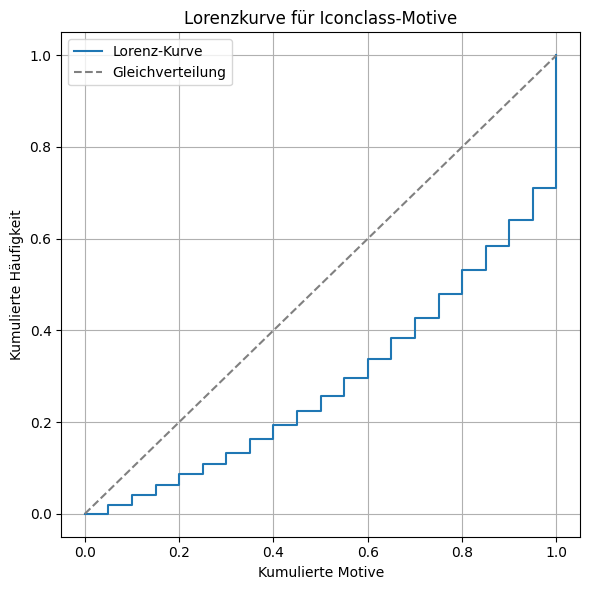

🔹 MODUS: 49L7 - handwriting, written text (1974x)
🔹 MEDIAN der Häufigkeiten: 241.0
🔹 GINI-Koeffizient: 0.3825


In [ ]:
# Berechnung von Modus, Median, Lorenzkurve und Gini-Koeffizient

df = pd.read_csv("iconclass_top20.csv")

# 1. MODUS – häufigstes Motiv
modus = df.loc[df["Absolute Frequency"].idxmax()]

# 2. MEDIAN – zentraler Wert der Häufigkeitsverteilung
median_value = df["Absolute Frequency"].median()

# 3. LORENZKURVE & GINI
def plot_lorenz_curve(values, title="Lorenzkurve für Iconclass-Motive"):
    sorted_vals = np.sort(values)
    cumvals = np.cumsum(sorted_vals)
    cumvals = np.insert(cumvals, 0, 0) 
    cumvals = cumvals / cumvals[-1]
    x_vals = np.linspace(0, 1, len(cumvals))

    plt.figure(figsize=(6, 6))
    plt.plot(x_vals, cumvals, drawstyle='steps-post', label="Lorenz-Kurve")
    plt.plot([0,1], [0,1], linestyle='--', color='gray', label="Gleichverteilung")
    plt.title(title)
    plt.xlabel("Kumulierte Motive")
    plt.ylabel("Kumulierte Häufigkeit")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def gini_coefficient(values):
    sorted_vals = np.sort(values)
    n = len(values)
    cumvals = np.cumsum(sorted_vals)
    gini = (n + 1 - 2 * np.sum(cumvals) / cumvals[-1]) / n
    return round(gini, 4)

# Daten vorbereiten
freqs = df["Absolute Frequency"].values

# 4. Plot & Gini berechnen
plot_lorenz_curve(freqs)
gini = gini_coefficient(freqs)

# Ergebnisse ausgeben
print("🔹 MODUS:", modus["ICONCLASS"], "-", modus["Label"], f"({modus['Absolute Frequency']}x)")
print("🔹 MEDIAN der Häufigkeiten:", median_value)
print("🔹 GINI-Koeffizient:", gini)


# Abschließende Bemerkung

Die hier dokumentierten Schritte bilden die technische Grundlage für die strukturierte Erschließung, Annotation und Analyse der Baldaev-Sammlung. Durch die systematische Anwendung von Datenverarbeitung, semantischer Normierung und XML-Export im LIDO-Standard wurde ein reproduzierbarer Workflow geschaffen. Die Kombination aus automatisierten Prozessen und manueller Qualitätskontrolle gewährleistet eine belastbare Datenbasis für weiterführende Analysen sowie künftige Erweiterungen der Sammlung. Das Notebook versteht sich damit als methodischer Baustein innerhalb eines umfassenderen Forschungs- und Erschließungsvorhabens.